# Project

Alexis COTTEZ - December 21st, 2018 - 5:15PM

**Deadline: December 21st, 2018 - 11:59PM**

> Import needed packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pyspark
sc = pyspark.SparkContext()
sc._conf.getAll()

#import org.apache.spark.sql.SQLContext
sqlsc = pyspark.SQLContext(sc)
spark = sqlsc.sparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd

## Data Preparation – step 1 – Merging gas prices files

In [3]:
prix2017_ddf = sqlsc.read.option('sep',';').option('header','false').option('inferSchema','true').csv('data/Prix2017.csv')
prix2016_ddf = sqlsc.read.option('sep',';').option('header','false').option('inferSchema','true').csv('data/Prix2016.csv')
prix2018_ddf = sqlsc.read.option('sep',';').option('header','false').option('inferSchema','true').csv('data/Prix20181114.csv')
prix2015_ddf = sqlsc.read.option('sep',';').option('header','false').option('inferSchema','true').csv('data/Prix2015.csv')

In [4]:
prix_ddf = prix2015_ddf.union(prix2016_ddf).union(prix2017_ddf).union(prix2018_ddf)
prix_ddf.count()

14192497

There are 14,192,497.0 observations in the 2015 to 2018 (November) total file.

In [5]:
prix_ddf = prix_ddf.selectExpr(
    '_c0 as id_station', 
    '_c1 as code_postal',
    '_c2 as type_station',
    '_c3 as latitude',
    '_c4 as longitude',
    '_c5 as date_releve',
    '_c6 as type_carburant',
    '_c7 as libelle_carburant',
    '_c8/1000 as prix'
).dropna()

In [6]:
prix_ddf.count()

14173853

> Less than 0.14% of data was NA, I choose to drop them all.

In [7]:
prix_ddf.show(5)

+----------+-----------+------------+---------+---------+-------------------+--------------+-----------------+-----+
|id_station|code_postal|type_station| latitude|longitude|        date_releve|type_carburant|libelle_carburant| prix|
+----------+-----------+------------+---------+---------+-------------------+--------------+-----------------+-----+
|   1000001|       1000|           R|4620114.0| 519791.0|2015-01-02 11:01:45|             1|           Gazole|1.141|
|   1000001|       1000|           R|4620114.0| 519791.0|2015-01-03 09:01:42|             1|           Gazole|1.141|
|   1000001|       1000|           R|4620114.0| 519791.0|2015-01-07 10:01:44|             1|           Gazole|1.141|
|   1000001|       1000|           R|4620114.0| 519791.0|2015-01-08 10:01:06|             1|           Gazole|1.115|
|   1000001|       1000|           R|4620114.0| 519791.0|2015-01-09 10:01:19|             1|           Gazole|1.115|
+----------+-----------+------------+---------+---------+-------

Let's make usable our price table in Spark environment.

In [8]:
sqlsc.registerDataFrameAsTable(prix_ddf, 'prix')

Explication of functions:
    - day(.): returns the day when . is a date
    - weekofyear(.): gives us the week of the year when . is a date (Year, month, day, hour) due to is coding format 
    - month(.): returns the month
    - year(.): gives the year
    - latitude/100,000 in order to have a 4,... format of latitude (same for longitude)
    

In [9]:
spark.sql(
    'SELECT  id_station, code_postal, type_station, latitude/100000 as latitude, longitude/100000 as longitude, date_releve, year(date_releve) as annee, month(date_releve) as mois, weekofyear(date_releve) as semaine, day(date_releve) as jour, type_carburant, libelle_carburant, prix '
    'FROM prix '
).cache().createOrReplaceTempView('prix')

In [10]:
spark.sql(
    'SELECT * '
    'FROM prix '
).show(20)

+----------+-----------+------------+--------+---------+-------------------+-----+----+-------+----+--------------+-----------------+-----+
|id_station|code_postal|type_station|latitude|longitude|        date_releve|annee|mois|semaine|jour|type_carburant|libelle_carburant| prix|
+----------+-----------+------------+--------+---------+-------------------+-----+----+-------+----+--------------+-----------------+-----+
|   1000001|       1000|           R|46.20114|  5.19791|2015-01-02 11:01:45| 2015|   1|      1|   2|             1|           Gazole|1.141|
|   1000001|       1000|           R|46.20114|  5.19791|2015-01-03 09:01:42| 2015|   1|      1|   3|             1|           Gazole|1.141|
|   1000001|       1000|           R|46.20114|  5.19791|2015-01-07 10:01:44| 2015|   1|      2|   7|             1|           Gazole|1.141|
|   1000001|       1000|           R|46.20114|  5.19791|2015-01-08 10:01:06| 2015|   1|      2|   8|             1|           Gazole|1.115|
|   1000001|       1

## Data Preparation – step 2 – Deduplicating stations

In [11]:
stations2018_ddf = (spark.read.load('data/Stations2018.csv', 
                                format='csv', sep='|', header='false', inferSchema='true')
                .selectExpr(
                    '_c0 as id_station', 
                    '_c1 as code_postal',
                    '_c2 as type_station',
                    '_c3/100000 as longitude',
                    '_c4/100000 as latitude',
                    '_c5 as rue',
                    '_c6 as ville'
                )
                .dropna()
                .cache()
                )

stations2017_ddf = (spark.read.load('data/Stations2017.csv', 
                                format='csv', sep='|', header='false', inferSchema='true')
                .selectExpr(
                    '_c0 as id_station', 
                    '_c1 as code_postal',
                    '_c2 as type_station',
                    '_c3/100000 as longitude',
                    '_c4/100000 as latitude',
                    '_c5 as rue',
                    '_c6 as ville'
                )
                .dropna()
                .cache()
                )

stations2016_ddf = (spark.read.load('data/Stations2016.csv', 
                                format='csv', sep='|', header='false', inferSchema='true')
                .selectExpr(
                    '_c0 as id_station', 
                    '_c1 as code_postal',
                    '_c2 as type_station',
                    '_c3/100000 as longitude',
                    '_c4/100000 as latitude',
                    '_c5 as rue',
                    '_c6 as ville'
                )
                .dropna()
                .cache()
                )

> /!\ We observe an inversion in latitude/longitude when one or both is/are negative !

In [12]:
stations_ddf = stations2016_ddf.union(stations2017_ddf).union(stations2018_ddf)
stations_ddf.count()

37439

There are 37,439 observations in stations total file (2016 to 2018)

In [13]:
stations_ddf.show(5)

+----------+-----------+------------+-------------+-------------+--------------------+--------------------+
|id_station|code_postal|type_station|    longitude|     latitude|                 rue|               ville|
+----------+-----------+------------+-------------+-------------+--------------------+--------------------+
|   1000001|       1000|           R|     46.20114|      5.19791|596 AVENUE DE TRE...|SAINT-DENIS-LèS-B...|
|   1000002|       1000|           R|     46.21842|      5.22767| 16 Avenue de Marboz|     BOURG-EN-BRESSE|
|   1000004|       1000|           R|     46.18836|      5.24447|20 Avenue du Maré...|     Bourg-en-Bresse|
|   1000005|       1000|           R|46.2009359235|5.19942024022|642 Avenue de Tré...|SAINT-DENIS-LèS-B...|
|   1000006|       1000|           R|     46.20754|      5.23758|1 Boulevard John ...|     BOURG-EN-BRESSE|
+----------+-----------+------------+-------------+-------------+--------------------+--------------------+
only showing top 5 rows



Let's build a 'station' unique id.
To build it, I choose to concat the street and city name of all observations in order to be the key to the unique id process.

In [14]:
sqlsc.registerDataFrameAsTable(stations_ddf, 'station')
spark.sql(
    'SELECT *, concat(rue,ville) as adresse '
    'FROM station '
    'ORDER BY adresse '
    ).cache().createOrReplaceTempView('station')

Taking only distinct adresse, we will chose the maximum id_station in order to build the unique id for a same station (located at the same place).

In [15]:
spark.sql(
    'SELECT distinct(adresse), max(id_station) as id_unique, code_postal, type_station, longitude, latitude  '
    'FROM station '
    'GROUP BY adresse, code_postal, type_station, longitude, latitude '
    'ORDER BY adresse '
    ).cache().createOrReplaceTempView('station_clean')

In [16]:
spark.sql(
    'SELECT * '
    'FROM station_clean '
    ).show(20)

+--------------------+---------+-----------+------------+---------+--------+
|             adresse|id_unique|code_postal|type_station|longitude|latitude|
+--------------------+---------+-----------+------------+---------+--------+
| 180 Route Nation...| 60730001|      60730|           R| 49.28908| 2.20085|
| Aire de FleuryFL...| 91700002|      91700|           R| 48.62404| 2.36962|
| Allée Anne de Pi...|  2600001|       2600|           R| 49.25086| 3.08205|
| Allée de la Comm...| 79260004|      79260|           R| 46.35519|-0.31186|
| Allée de la Libé...| 57100003|      57100|           R|  49.3632|  6.1549|
| Allée du Chêne V...| 35650001|      35650|           R| 48.09564|-1.77789|
| Au Village de la...| 71800002|      71800|           R| 46.29043| 4.32281|
| Autoroute de Nor...| 27210006|      27210|           A| 49.37268| 0.65987|
| Autoroute de Nor...| 14730002|      14730|           A| 49.16711|-0.28803|
| Autoroute de l'E...| 51400005|      51400|           A| 49.12311| 4.23946|

In [17]:
spark.sql(
    'SELECT * '
    'FROM station_clean '
    ).count()

18505

We can extract an id_unique table.

In [18]:
spark.sql(
    'SELECT distinct(adresse), id_unique, longitude, latitude '
    'FROM station_clean '
    'ORDER BY adresse '
    #).show(20)
    ).cache().createOrReplaceTempView('ad_id')

> So we can construct the mapple table with id and id_unique.

In [19]:
spark.sql(
    'SELECT station.adresse, station.id_station, ad_id.id_unique, ad_id.longitude, station.latitude '
    'FROM station, ad_id '
    'WHERE station.adresse = ad_id.adresse and  station.longitude = ad_id.longitude and station.latitude = ad_id.latitude '
    'GROUP BY station.adresse, station.id_station, ad_id.id_unique, ad_id.longitude, station.latitude'
    ).cache().createOrReplaceTempView('mapple')

In [20]:
spark.sql(
    'SELECT * '
    'FROM mapple '
    ).show(20)

+--------------------+----------+---------+---------+--------+
|             adresse|id_station|id_unique|longitude|latitude|
+--------------------+----------+---------+---------+--------+
| 180 Route Nation...|  60730001| 60730001| 49.28908| 2.20085|
| Aire de FleuryFL...|  91700002| 91700002| 48.62404| 2.36962|
| Allée Anne de Pi...|   2600001|  2600001| 49.25086| 3.08205|
| Allée de la Comm...|  79260004| 79260004| 46.35519|-0.31186|
| Allée de la Libé...|  57100003| 57100003|  49.3632|  6.1549|
| Allée du Chêne V...|  35650001| 35650001| 48.09564|-1.77789|
| Au Village de la...|  71800002| 71800002| 46.29043| 4.32281|
| Autoroute de Nor...|  27210006| 27210006| 49.37268| 0.65987|
| Autoroute de Nor...|  14730002| 14730002| 49.16711|-0.28803|
| Autoroute de l'E...|  51400002| 51400005| 49.12311| 4.23946|
| Autoroute de l'E...|  51400005| 51400005| 49.12311| 4.23946|
| Autoroute des An...|  62860005| 62860005| 50.27825| 2.96596|
| Autoroute du Nor...|  59113004| 59113004| 49.83909|  

We can merge it to our station table in order to have a full table with both id.

In [21]:
spark.sql(
    'SELECT prix.id_station, prix.code_postal, prix.type_station, prix.latitude, prix.longitude, prix.date_releve, prix.annee, prix.mois, prix.semaine, prix.jour, prix.type_carburant, prix.libelle_carburant, prix.prix, mapple.id_unique, mapple.adresse '
    'FROM prix, mapple '
    'WHERE prix.id_station = mapple.id_station '
    'GROUP BY prix.id_station, prix.code_postal, prix.type_station, prix.latitude, prix.longitude, prix.date_releve, prix.annee, prix.mois, prix.semaine, prix.jour, prix.type_carburant, prix.libelle_carburant, prix.prix, mapple.id_unique, mapple.adresse '
    #).show(10)
    ).cache().createOrReplaceTempView('prix_clean')

In [22]:
spark.sql(
    'SELECT distinct(id_station) != id_unique as val , adresse '
    'FROM prix_clean '
    'ORDER by !val '
    ).show(25)

+-----+--------------------+
|  val|             adresse|
+-----+--------------------+
| true|Autoroute de l'Es...|
| true|Rue des Hautes Co...|
| true|72 COURS TOLSTOIV...|
| true|39 Boulevard de l...|
| true|Rue de Vauluisant...|
| true|Route du Barcarès...|
| true|BD HENRI DUNANTAN...|
| true|47 COURS EMILE ZO...|
| true|AVENUE CHARLES LI...|
| true|    KERNOUSKervignac|
| true|7 Rue du Général ...|
| true|Rue de la CrayVOU...|
| true| Rue Jean le Cout...|
| true|BOULEVARD GUY MOL...|
| true|Route d'UzèsSaint...|
| true|Route de Saint-Am...|
| true|Avenue de RodezPo...|
| true|Autoroute de l'Es...|
|false|Rue de la GareCHA...|
|false|170 Avenue d'Auen...|
|false|Route Nationale 3...|
|false|13 GRANDE RUEAMANCEY|
|false|1394 Avenue de Dr...|
|false|27 Avenue du Géné...|
|false|17 Quai Félix Fau...|
+-----+--------------------+
only showing top 25 rows



There were 18 stations where the id changes for a same station.

## Data Preparation – step 3 - price index for each station per day

In [23]:
spark.sql(
    'SELECT * '
    'FROM prix_clean '
    'ORDER by id_unique, date_releve '
    ).show(25)

+----------+-----------+------------+--------+---------+-------------------+-----+----+-------+----+--------------+-----------------+-----+---------+--------------------+
|id_station|code_postal|type_station|latitude|longitude|        date_releve|annee|mois|semaine|jour|type_carburant|libelle_carburant| prix|id_unique|             adresse|
+----------+-----------+------------+--------+---------+-------------------+-----+----+-------+----+--------------+-----------------+-----+---------+--------------------+
|   1000001|       1000|           R|46.20114|  5.19791|2015-01-02 11:01:45| 2015|   1|      1|   2|             2|             SP95|1.311|  1000001|596 AVENUE DE TRE...|
|   1000001|       1000|           R|46.20114|  5.19791|2015-01-02 11:01:45| 2015|   1|      1|   2|             1|           Gazole|1.141|  1000001|596 AVENUE DE TRE...|
|   1000001|       1000|           R|46.20114|  5.19791|2015-01-02 11:01:46| 2015|   1|      1|   2|             6|             SP98|1.327|  1000

We can now construct a variable which recapitulate the national mean price per day and per gas type.

In [24]:
spark.sql(
    'SELECT AVG(prix) AS moyenne_nationale, jour, mois, annee, libelle_carburant '
    'FROM prix_clean '
    'GROUP BY annee, mois, jour, libelle_carburant '
    'ORDER BY annee, mois, jour '
    #).show(30)
    ).cache().createOrReplaceTempView('moyenne_natio')

In [25]:
spark.sql(
    'SELECT * '
    'FROM moyenne_natio '
    'ORDER BY annee, mois, jour '
    ).show(30)

+------------------+----+----+-----+-----------------+
| moyenne_nationale|jour|mois|annee|libelle_carburant|
+------------------+----+----+-----+-----------------+
|0.9079463087248327|   1|   1| 2015|             GPLc|
|1.4057822878228778|   1|   1| 2015|             SP98|
|1.2027785016286643|   1|   1| 2015|           Gazole|
|1.3555525812619502|   1|   1| 2015|              E10|
| 0.937842105263158|   1|   1| 2015|              E85|
|1.3539901960784313|   1|   1| 2015|             SP95|
|0.8101080000000003|   2|   1| 2015|             GPLc|
|0.8713706293706294|   2|   1| 2015|              E85|
|1.2946060482223138|   2|   1| 2015|             SP95|
|1.1329152334152335|   2|   1| 2015|           Gazole|
|1.3482048079925064|   2|   1| 2015|             SP98|
|1.2804677121771217|   2|   1| 2015|              E10|
|1.2933030907278162|   3|   1| 2015|              E10|
|0.8549285714285716|   3|   1| 2015|              E85|
|1.2921892307692304|   3|   1| 2015|             SP95|
|1.3477750

We can add this mean to our big price table.

In [26]:
spark.sql(
    'SELECT prix_clean.id_station, prix_clean.code_postal, prix_clean.date_releve, prix_clean.annee, prix_clean.mois, '
    'prix_clean.semaine, prix_clean.jour, prix_clean.libelle_carburant, prix_clean.prix, prix_clean.id_unique, '
    'prix_clean.adresse, moyenne_natio.moyenne_nationale '
    'FROM prix_clean, moyenne_natio '
    'WHERE prix_clean.jour = moyenne_natio.jour and prix_clean.mois = moyenne_natio.mois and '
    'prix_clean.annee = moyenne_natio.annee and prix_clean.libelle_carburant = moyenne_natio.libelle_carburant '
    'GROUP BY prix_clean.id_station, prix_clean.code_postal, prix_clean.date_releve, prix_clean.annee, prix_clean.mois, '
    'prix_clean.semaine, prix_clean.jour, prix_clean.libelle_carburant, prix_clean.prix, prix_clean.id_unique, '
    'prix_clean.adresse, moyenne_natio.moyenne_nationale '
    ).cache().createOrReplaceTempView('prix_clean')

In [27]:
spark.sql(
    'SELECT * '
    'FROM prix_clean '
    ).show(20)

+----------+-----------+-------------------+-----+----+-------+----+-----------------+-----+---------+--------------------+------------------+
|id_station|code_postal|        date_releve|annee|mois|semaine|jour|libelle_carburant| prix|id_unique|             adresse| moyenne_nationale|
+----------+-----------+-------------------+-----+----+-------+----+-----------------+-----+---------+--------------------+------------------+
|   3360001|       3360|2015-10-16 11:10:13| 2015|  10|     42|  16|              E10| 1.27|  3360001|rue du pavéAINAY-...|1.2869536907100756|
|   9110002|       9110|2015-01-30 09:01:44| 2015|   1|      5|  30|           Gazole|1.119|  9110002|10/13 Allée du bo...|1.1128577850429098|
|   9190002|       9190|2015-07-03 11:07:51| 2015|   7|     27|   3|             SP98|1.423|  9190002|Le Pont du BaupSA...| 1.469680276517607|
|  12100004|      12100|2015-03-16 08:03:07| 2015|   3|     12|  16|             SP98|1.399| 12100004|AVENUE DU PONT LE...|1.4401337987201852|

> We can build an index_price thanks to this national price mean per gas.

In [28]:
spark.sql(
    'SELECT *, 100*(1 + (prix - moyenne_nationale)/moyenne_nationale) as index_prix '
    'FROM prix_clean '
    'ORDER BY id_unique, date_releve '
    ).cache().createOrReplaceTempView('prix_clean')

In [29]:
spark.sql(
    'SELECT * '
    'FROM prix_clean '
    'ORDER BY id_unique, date_releve '
    ).show(20)

+----------+-----------+-------------------+-----+----+-------+----+-----------------+-----+---------+--------------------+------------------+------------------+
|id_station|code_postal|        date_releve|annee|mois|semaine|jour|libelle_carburant| prix|id_unique|             adresse| moyenne_nationale|        index_prix|
+----------+-----------+-------------------+-----+----+-------+----+-----------------+-----+---------+--------------------+------------------+------------------+
|   1000001|       1000|2015-01-02 11:01:45| 2015|   1|      1|   2|           Gazole|1.141|  1000001|596 AVENUE DE TRE...|1.1329152334152335|100.71362502209406|
|   1000001|       1000|2015-01-02 11:01:45| 2015|   1|      1|   2|             SP95|1.311|  1000001|596 AVENUE DE TRE...|1.2946060482223138|101.26632745152067|
|   1000001|       1000|2015-01-02 11:01:46| 2015|   1|      1|   2|             SP98|1.327|  1000001|596 AVENUE DE TRE...|1.3482048079925064| 98.42718199291392|
|   1000001|       1000|2015

## Data Visualization (1/2)

> We only keep needed variables.

In [30]:
prix_natio_df = spark.sql(
    'SELECT DISTINCT libelle_carburant, date(date_releve) as date, moyenne_nationale '
    'FROM prix_clean '
    'ORDER BY date, libelle_carburant '
).toPandas() 

In [31]:
prix_natio_df.head()

,libelle_carburant,date,moyenne_nationale
0,E10,2015-01-01,1.355553
1,E85,2015-01-01,0.937842
2,GPLc,2015-01-01,0.907946
3,Gazole,2015-01-01,1.202779
4,SP95,2015-01-01,1.353990


Text(0.5,0.98,'Evolution of average gas price over France')

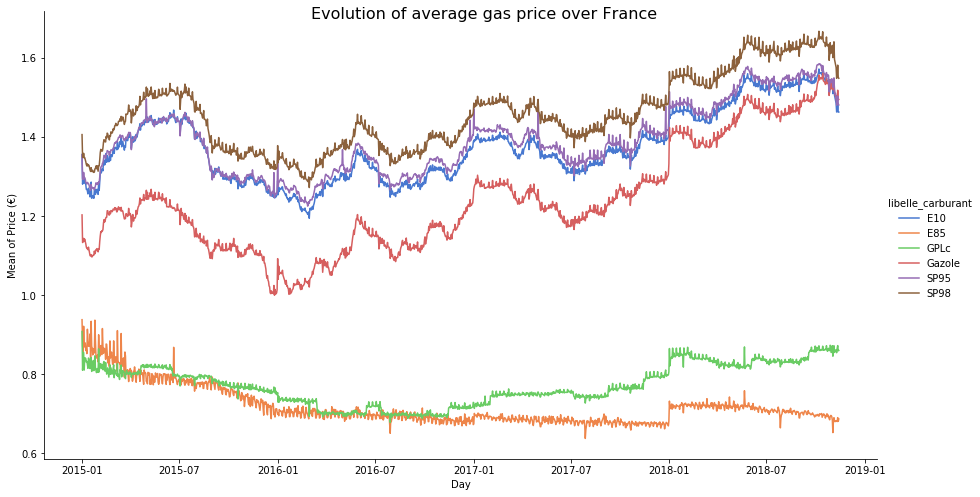

In [32]:
graph = sns.FacetGrid(prix_natio_df.sort_values(by=['libelle_carburant','date']), hue='libelle_carburant', size=7, aspect=16/9, palette="muted")
graph.map(plt.plot, "date", "moyenne_nationale")
graph.add_legend()
graph.set_axis_labels("Day", "Mean of Price (€)")
graph.fig.suptitle('Evolution of average gas price over France', size=16)

So we can observe that....

## Data Visualization (2/2)

> Let's compute average price index per gas type over departments.

I decide to divide by 1000 all post code except the 97 one's which are devide by 100 for instance for Réunion

In [65]:
spark.sql(
    'SELECT libelle_carburant, '
    'CASE WHEN code_postal<97000 then int(ROUND(code_postal / 1000, 0)) '
    'ELSE int(ROUND(code_postal / 100, 0)) END as dep, '
    'ROUND(avg(index_prix),3) as average_index_price '
    'FROM prix_clean '
    'GROUP BY dep, libelle_carburant '
    'ORDER BY dep'
    ).cache().createOrReplaceTempView('index_prix_dep')

In [66]:
spark.sql(
    'SELECT * '
    'FROM index_prix_dep '
    ).show(20)

+-----------------+---+-------------------+
|libelle_carburant|dep|average_index_price|
+-----------------+---+-------------------+
|              E85|  1|            108.189|
|           Gazole|  1|            100.918|
|             GPLc|  1|             109.63|
|              E10|  1|            100.812|
|             SP95|  1|             99.582|
|             SP98|  1|            100.377|
|             SP98|  2|             98.923|
|              E10|  2|             99.141|
|           Gazole|  2|             98.681|
|             GPLc|  2|            100.316|
|             SP95|  2|             99.187|
|              E85|  2|             94.442|
|              E10|  3|            100.625|
|             SP98|  3|            101.106|
|              E85|  3|             90.369|
|             SP95|  3|            100.417|
|           Gazole|  3|            101.001|
|             GPLc|  3|            104.687|
|             SP95|  4|            100.798|
|             GPLc|  4|         

In [68]:
prix_dep_df = spark.sql(
    'SELECT * '
    'FROM index_prix_dep '
    'ORDER BY dep '
    ).toPandas()
prix_dep_df.head(15)

,libelle_carburant,dep,average_index_price
0,E85,1,108.189
1,Gazole,1,100.918
2,GPLc,1,109.630
3,E10,1,100.812
4,SP95,1,99.582
5,SP98,1,100.377
6,SP98,2,98.923
7,E10,2,99.141
8,Gazole,2,98.681
9,GPLc,2,100.316


> We can build one table per gas type in order to build, in fine, 6 maps (one for each gas type).

In [69]:
prix_dep_df_E85 = prix_dep_df[ prix_dep_df["libelle_carburant"]=='E85'].set_index("dep", drop=True)
prix_dep_df_E85 = prix_dep_df_E85.drop("libelle_carburant", axis=1)
dict_prix_dep_E85 = prix_dep_df_E85.T.to_dict(orient="index")

prix_dep_df_Gazole = prix_dep_df[ prix_dep_df["libelle_carburant"]=='Gazole'].set_index("dep", drop=True)
prix_dep_df_Gazole = prix_dep_df_Gazole.drop("libelle_carburant", axis=1)
dict_prix_dep_Gazole = prix_dep_df_Gazole.T.to_dict(orient="index")

prix_dep_df_GPLc = prix_dep_df[ prix_dep_df["libelle_carburant"]=='GPLc'].set_index("dep", drop=True)
prix_dep_df_GPLc = prix_dep_df_GPLc.drop("libelle_carburant", axis=1)
dict_prix_dep_GPLc = prix_dep_df_GPLc.T.to_dict(orient="index")

prix_dep_df_E10 = prix_dep_df[ prix_dep_df["libelle_carburant"]=='E10'].set_index("dep", drop=True)
prix_dep_df_E10 = prix_dep_df_E10.drop("libelle_carburant", axis=1)
dict_prix_dep_E10 = prix_dep_df_E10.T.to_dict(orient="index")

prix_dep_df_SP95 = prix_dep_df[ prix_dep_df["libelle_carburant"]=='SP95'].set_index("dep", drop=True)
prix_dep_df_SP95 = prix_dep_df_SP95.drop("libelle_carburant", axis=1)
dict_prix_dep_SP95 = prix_dep_df_SP95.T.to_dict(orient="index")

prix_dep_df_SP98 = prix_dep_df[ prix_dep_df["libelle_carburant"]=='SP98'].set_index("dep", drop=True)
prix_dep_df_SP98 = prix_dep_df_SP98.drop("libelle_carburant", axis=1)
dict_prix_dep_SP98 = prix_dep_df_SP98.T.to_dict(orient="index")

> Represent France department average price index heatmaps for each gas type


The render is not possible directly in the notebook.

In [37]:
import pygal.maps.fr

In [71]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Department average price index for Gazole'
fr_chart.add('Gazole', dict_prix_dep_Gazole['average_index_price'])
fr_chart.render_in_browser()

file:///var/folders/8v/9mjtm7gj2kzcxf_w3tnrqjbm0000gp/T/tmp22x4hr38.html


![Gazole](Gazole.png)

In [72]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Department average price index for E85'
fr_chart.add('E85', dict_prix_dep_E85['average_index_price'])
fr_chart.render_in_browser()

file:///var/folders/8v/9mjtm7gj2kzcxf_w3tnrqjbm0000gp/T/tmp01i92bsr.html


![E85](E85.png)

In [73]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Department average price index for SP95'
fr_chart.add('SP95', dict_prix_dep_SP95['average_index_price'])
fr_chart.render_in_browser()

file:///var/folders/8v/9mjtm7gj2kzcxf_w3tnrqjbm0000gp/T/tmpcjebp3pk.html


![SP95](SP95.png)

In [74]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Department average price index for SP98'
fr_chart.add('SP98', dict_prix_dep_SP98['average_index_price'])
fr_chart.render_in_browser()

file:///var/folders/8v/9mjtm7gj2kzcxf_w3tnrqjbm0000gp/T/tmp8kko9cpv.html


![SP98](SP98.png)

In [75]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Department average price index for E10'
fr_chart.add('E10', dict_prix_dep_E10['average_index_price'])
fr_chart.render_in_browser()

file:///var/folders/8v/9mjtm7gj2kzcxf_w3tnrqjbm0000gp/T/tmpi5qndelk.html


![E10](E10.png)

In [76]:
fr_chart = pygal.maps.fr.Departments(human_readable=True)
fr_chart.title = 'Department average price index for GPLc'
fr_chart.add('GPLc', dict_prix_dep_GPLc['average_index_price'])
fr_chart.render_in_browser()

file:///var/folders/8v/9mjtm7gj2kzcxf_w3tnrqjbm0000gp/T/tmpwjpocfws.html


![GPLc](GPLc.png)

## Modeling 1 – Option 1 – Forecast next day price

- Build a model based on Spark MLlib to forecast the next day price **for a gas type in a station**
- Do NOT consider using time series models (such as AR/ARMA/ARIMA) but rely on existing techniques from Spark MLlib such as LinearRegression, RandomForestRegressor, etc.
- Provide **relevant accuracy measures** and a **relevant dispersion plot between actual & forecast**


- *Hints: consider using lag features (such as price of the day before, and the day before, etc.) to build the model*
- *Important Notice: we do not expect model fine tuning, but more a working pipeline*

In [44]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.ml.feature import * 

> Test our modelisation on 1 Station (1000001) for 1 gas type (Gazole)

I build until 8 days of lag

In [45]:
prix_reg_test = spark.sql(
    'SELECT id_unique, date(date_releve) as date, libelle_carburant, prix, LAG(prix,1) OVER (ORDER BY id_unique, libelle_carburant, date(date_releve) ) AS prix_1, LAG(prix,2) OVER (ORDER BY id_unique, libelle_carburant, date(date_releve)) AS prix_2, '
    'LAG(prix,3) OVER (ORDER BY id_unique, libelle_carburant, date(date_releve) ) AS prix_3, LAG(prix,4) OVER (ORDER BY id_unique, libelle_carburant, date(date_releve) ) AS prix_4, '
    'LAG(prix,5) OVER (ORDER BY id_unique, libelle_carburant, date(date_releve) ) AS prix_5, LAG(prix,6) OVER (ORDER BY id_unique, libelle_carburant, date(date_releve) ) AS prix_6, '
    'LAG(prix,7) OVER (ORDER BY id_unique, libelle_carburant,date(date_releve)) AS prix_7, LAG(prix,8) OVER (ORDER BY id_unique, libelle_carburant,date(date_releve)) AS prix_8 '
    'FROM prix_clean '
    'WHERE id_unique = 1000001 AND libelle_carburant = "Gazole" '
    'ORDER BY libelle_carburant, date(date_releve)'
    )

In [46]:
prix_reg_test.show(10)

+---------+----------+-----------------+-----+------+------+------+------+------+------+------+------+
|id_unique|      date|libelle_carburant| prix|prix_1|prix_2|prix_3|prix_4|prix_5|prix_6|prix_7|prix_8|
+---------+----------+-----------------+-----+------+------+------+------+------+------+------+------+
|  1000001|2015-01-02|           Gazole|1.141|  null|  null|  null|  null|  null|  null|  null|  null|
|  1000001|2015-01-03|           Gazole|1.141| 1.141|  null|  null|  null|  null|  null|  null|  null|
|  1000001|2015-01-07|           Gazole|1.141| 1.141| 1.141|  null|  null|  null|  null|  null|  null|
|  1000001|2015-01-08|           Gazole|1.115| 1.141| 1.141| 1.141|  null|  null|  null|  null|  null|
|  1000001|2015-01-09|           Gazole|1.115| 1.115| 1.141| 1.141| 1.141|  null|  null|  null|  null|
|  1000001|2015-01-10|           Gazole|1.099| 1.115| 1.115| 1.141| 1.141| 1.141|  null|  null|  null|
|  1000001|2015-01-14|           Gazole|1.088| 1.099| 1.115| 1.115| 1.141

In [47]:
prix_reg_test = prix_reg_test.dropna()

In [48]:
prix_reg_test.show(10)

+---------+----------+-----------------+-----+------+------+------+------+------+------+------+------+
|id_unique|      date|libelle_carburant| prix|prix_1|prix_2|prix_3|prix_4|prix_5|prix_6|prix_7|prix_8|
+---------+----------+-----------------+-----+------+------+------+------+------+------+------+------+
|  1000001|2015-01-24|           Gazole|1.074| 1.074| 1.088| 1.099| 1.115| 1.115| 1.141| 1.141| 1.141|
|  1000001|2015-01-27|           Gazole|1.088| 1.074| 1.074| 1.088| 1.099| 1.115| 1.115| 1.141| 1.141|
|  1000001|2015-01-28|           Gazole|1.088| 1.088| 1.074| 1.074| 1.088| 1.099| 1.115| 1.115| 1.141|
|  1000001|2015-01-30|           Gazole|1.095| 1.088| 1.088| 1.074| 1.074| 1.088| 1.099| 1.115| 1.115|
|  1000001|2015-01-31|           Gazole|1.095| 1.095| 1.088| 1.088| 1.074| 1.074| 1.088| 1.099| 1.115|
|  1000001|2015-02-02|           Gazole|1.095| 1.095| 1.095| 1.088| 1.088| 1.074| 1.074| 1.088| 1.099|
|  1000001|2015-02-03|           Gazole|1.095| 1.095| 1.095| 1.095| 1.088

In [49]:
vectorAssembler = VectorAssembler(inputCols = ["prix_1", "prix_2", "prix_3", "prix_4", "prix_5", "prix_6", "prix_7","prix_8"], outputCol = 'features')
vprix_reg_test = vectorAssembler.transform(prix_reg_test)
vprix_reg_test = vprix_reg_test.select(['features', 'prix', 'date'])
vprix_reg_test.show(10)

+--------------------+-----+----------+
|            features| prix|      date|
+--------------------+-----+----------+
|[1.074,1.088,1.09...|1.074|2015-01-24|
|[1.074,1.074,1.08...|1.088|2015-01-27|
|[1.088,1.074,1.07...|1.088|2015-01-28|
|[1.088,1.088,1.07...|1.095|2015-01-30|
|[1.095,1.088,1.08...|1.095|2015-01-31|
|[1.095,1.095,1.08...|1.095|2015-02-02|
|[1.095,1.095,1.09...|1.095|2015-02-03|
|[1.095,1.095,1.09...|1.109|2015-02-04|
|[1.109,1.095,1.09...|1.109|2015-02-05|
|[1.109,1.109,1.09...|1.119|2015-02-05|
+--------------------+-----+----------+
only showing top 10 rows



> Split in a train and a test sample

In [50]:
splits = vprix_reg_test.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [51]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='prix')
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.8236703197128765,0.12749201305967459,0.03249213205628196,0.03365504638078969,0.01977877500597721,-0.00497563397539458,-0.02262748149265769,-0.011979308593934973]
Intercept: 0.003756370853697244


In [52]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R Squared (R^2) on train sample is : %f" % trainingSummary.r2)

RMSE: 0.008813
R Squared (R^2) on train sample is : 0.994929


In [54]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","prix","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="prix",metricName="r2")
# r2 - coefficient of determination
print("Coefficient of determination - R Squared (R^2) on test sample is = %g" % lr_evaluator.evaluate(lr_predictions))
# Root Mean Square Error
rmse = lr_evaluator.evaluate(lr_predictions)
print("Root Mean Square Error (RMSE) on test sample is = %.3f" % rmse)
# Mean Square Error
mse = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "mse"})
print("Mean Square Error (MSE) on test sample is = %.3f" % mse)
# Mean Absolute Error
mae = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "mae"})
print("Mean Absolute Error (MAE) on test sample is = %.3f" % mae)


+------------------+-----+--------------------+
|        prediction| prix|            features|
+------------------+-----+--------------------+
|0.9793171040399304|0.978|[0.978,0.978,0.97...|
|0.9793171040399304|0.978|[0.978,0.978,0.97...|
|0.9793171040399304|1.026|[0.978,0.978,0.97...|
| 0.980831479847759|0.978|[0.978,0.978,1.00...|
|0.9848966333189674|0.978|[0.978,1.008,1.01...|
+------------------+-----+--------------------+
only showing top 5 rows

Coefficient of determination - R Squared (R^2) on test sample is = 0.973953
Root Mean Square Error (RMSE) on test sample is = 0.974
Mean Square Error (MSE) on test sample is = 0.000
Mean Absolute Error (MAE) on test sample is = 0.007


There is, obviously, some overfitting !!

> Let's make some graphs

In [55]:
data_pred = lr_predictions.toPandas() 
data_pred.head()

data_pred.date = pd.DatetimeIndex(data=data_pred.date)

Text(0.5,1,'Dspersion plot between price & forecast')

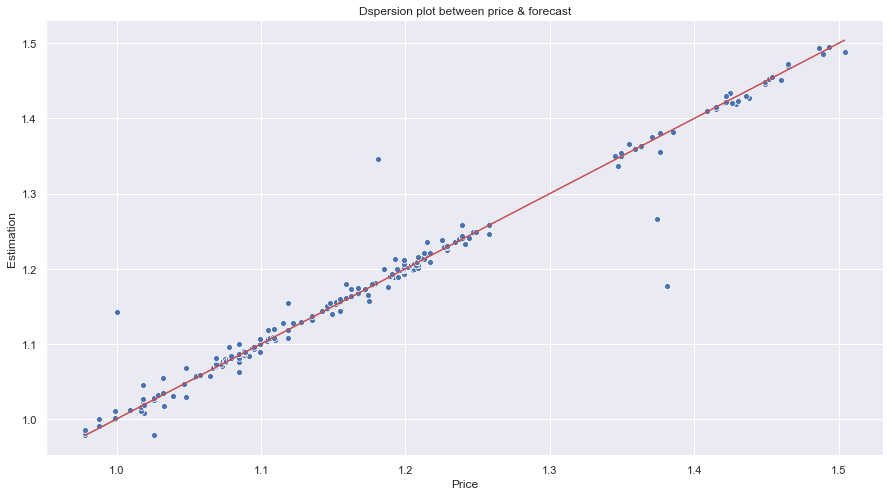

In [56]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(15,8))
#sns.regplot(x='prix',y='prediction', data=data_pred, color='b')
sns.scatterplot(x='prix',y='prediction', data=data_pred, color='b')
ax = sns.lineplot(x='prix', y='prix', data=data_pred, color='r')
ax.set(xlabel='Price', ylabel='Estimation')
ax.set_title("Dspersion plot between price & forecast")

Text(0.5,1,'Evolution plot of predicted and prices')

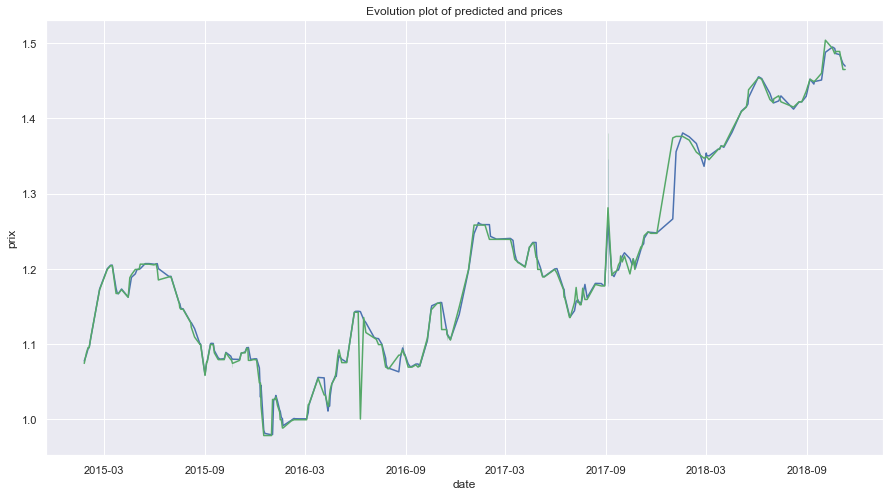

In [80]:
sns.set()
plt.figure(figsize=(15,8))
ax = sns.lineplot(x='date',y='prediction', data=data_pred, color='b')
sns.lineplot(x='date',y='prix', data=data_pred, color='g')
ax.set_title("Evolution plot of predicted and prices")

> **We could try it on the full sample but at this stage, no one output can be shown due to Java heap space problems (java.lang.OutOfMemoryError: Java heap space).**

In [ ]:
prix_reg = spark.sql(
    'SELECT id_unique, date_releve, libelle_carburant, prix, LAG(prix,1) OVER (ORDER BY id_unique, date(date_releve), libelle_carburant) AS prix_1, LAG(prix,2) OVER (ORDER BY id_unique, date(date_releve), libelle_carburant) AS prix_2, '
    'LAG(prix,3) OVER (ORDER BY id_unique, date(date_releve), libelle_carburant) AS prix_3, LAG(prix,4) OVER (ORDER BY id_unique, date(date_releve), libelle_carburant) AS prix_4, '
    'LAG(prix,5) OVER (ORDER BY id_unique, date(date_releve), libelle_carburant) AS prix_5, LAG(prix,6) OVER (ORDER BY id_unique, date(date_releve), libelle_carburant) AS prix_6, '
    'LAG(prix,7) OVER (ORDER BY id_unique, date(date_releve), libelle_carburant) AS prix_7,LAG(prix,8) OVER (ORDER BY id_unique, date(date_releve), libelle_carburant) AS prix_8  '
    'FROM prix_clean '
    'ORDER BY id_unique, date_releve '
    )

In [ ]:
train, test = spark.table('prix_reg').randomSplit([0.7, 0.3])

> We want to see the impact of all lags on the price.

In [ ]:
features = ["prix_1", "prix_2", "prix_3", "prix_4", "prix_5", "prix_6", "prix_7"]

In [ ]:
features = ["prix_1", "prix_2", "prix_3", "prix_4", "prix_5", "prix_6", "prix_7","prix_8"]
Tok = Tokenizer(inputCol="libelle_carburant", outputCol="Carburant") 
vectorAssembler = VectorAssembler(inputCols=features, outputCol="unscaled_features")
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")
lr = LinearRegression()
stages = [Tok, vectorAssembler, standardScaler, lr]
pipeline = Pipeline(stages=stages)
model = pipeline.fit(train)
prediction = model.transform(test)
prediction.show()

> We could observe some information on our model:

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
reg_data = RegressionEvaluator(labelCol="prix", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = reg_data.evaluate(prediction)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = reg_data.evaluate(prediction, {reg_data.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = reg_data.evaluate(prediction, {reg_data.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = reg_data.evaluate(prediction, {reg_data.metricName: "r2"})
print("r2: %.3f" %r2)

Thanks for reading.

Alexis COTTEZ - AMSE Student